In [1]:
import numpy as np
import pandas as pd
from genetics import loadRawGenoFile, unpackfullgenofile, unpackAndFilterSNPs
def load_snp_table(snp_table_filename):
    # Load the SNP table (assumed to be in CSV format for this example)
    snp_table = pd.read_csv(snp_table_filename)
    return snp_table

def filter_y_chromosome_snps(geno_filename, snp_table_filename, chunk_size=10000):
    # Load the SNP information table
    snp_table = load_snp_table(snp_table_filename)
    
    # Filter for Y chromosome SNPs (assuming a column 'chromosome' and 'snp_id')
    y_chromosome_snps = snp_table[snp_table['Chromosome'] == 24]['SNP']
    
    # Convert SNP IDs to indices (assuming you have a mapping function)
    snp_id_to_index = {snp_id: idx for idx, snp_id in enumerate(snp_table['SNP'])}
    y_snp_indices = [snp_id_to_index[snp_id] for snp_id in y_chromosome_snps if snp_id in snp_id_to_index]
    
    # Process the geno file in chunks and filter Y chromosome SNPs
    geno_file, nind, nsnp, rlen = loadRawGenoFile(geno_filename)
    geno = np.memmap(geno_filename, dtype='uint8', mode='r', shape=(nsnp, rlen))
    
    filtered_data = []
    
    for start in range(0, nsnp, chunk_size):
        end = min(start + chunk_size, nsnp)
        chunk = geno[start:end]
        chunk_unpacked = np.unpackbits(chunk, axis=1)[:, :(2 * nind)]
        
        # Find indices of Y chromosome SNPs in the current chunk
        chunk_indices = np.array([idx for idx in y_snp_indices if start <= idx < end])
        if chunk_indices.size > 0:
            chunk_filtered = chunk_unpacked[chunk_indices - start]
            filtered_data.append(chunk_filtered)
    
    return np.vstack(filtered_data) if filtered_data else np.array([])

# Example usage
filtered_y_chromosome_data = filter_y_chromosome_snps(
    r'C:\Users\91735\OneDrive\Desktop\freelance excel\Fiverr\Sachaat\Files\v54.1.p1_HO_public.geno',
    r'C:\Users\91735\OneDrive\Desktop\freelance excel\Fiverr\Sachaat\Analysis\v54.1.p1_HO_public (2).csv'
)


In [2]:
import pandas as pd

def load_ind_file(ind_filename):
    ind_data = pd.read_csv(ind_filename,low_memory=False)  
    return ind_data

ind_file = r'C:\Users\91735\OneDrive\Desktop\freelance excel\Fiverr\Sachaat\Analysis\v54.1.p1_HO_public.csv'
ind_data = load_ind_file(ind_file)

In [3]:
def create_filtered_ind_df(ind_data):
    relevant_columns = ['Genetic ID', 'SNPs hit on autosomal targets (Computed using easystats on 1240k snpset)']
    filtered_ind_data = ind_data[relevant_columns]
    return filtered_ind_data

filtered_ind_data = create_filtered_ind_df(ind_data)
print(filtered_ind_data.head())
filtered_ind_data.replace('..',np.nan,inplace=True)

     Genetic ID  \
0       I001.HO   
1       I002.HO   
2  IREJ-T006.HO   
3  IREJ-T009.HO   
4  IREJ-T022.HO   

  SNPs hit on autosomal targets (Computed using easystats on 1240k snpset)  
0                                                 ..                        
1                                                 ..                        
2                                                 ..                        
3                                                 ..                        
4                                                 ..                        


C:\Users\91735\AppData\Local\Temp\ipykernel_11336\4113635757.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ind_data.replace('..',np.nan,inplace=True)


In [4]:
import numpy as np
import pandas as pd

def filter_individuals_based_on_missing_data(geno_data, ind_data, missing_threshold=0.4):
    # Convert 'SNPs hit on autosomal targets' to numeric, setting errors='coerce' will replace invalid parsing with NaN
    ind_data['SNPs hit on autosomal targets (Computed using easystats on 1240k snpset)'] = pd.to_numeric(
        ind_data['SNPs hit on autosomal targets (Computed using easystats on 1240k snpset)'], errors='coerce')
    
    # Extract relevant columns
    ind_ids = ind_data['Genetic ID'].values
    snps_hit = ind_data['SNPs hit on autosomal targets (Computed using easystats on 1240k snpset)'].values
    
    # Count the total number of SNPs available
    total_snps = geno_data.shape[0]
    
    # Calculate the proportion of missing SNPs for each individual
    missing_data = 1 - (snps_hit / total_snps)
    
    # Filter out individuals with more than 40% missing data
    valid_individuals_mask = missing_data <= missing_threshold
    
    # Filter ind_data based on valid individuals
    filtered_ind_data = ind_data[valid_individuals_mask]
    valid_individual_ids = filtered_ind_data['Genetic ID'].values
    
    # Create a dictionary for fast lookup
    id_to_index = {id: idx for idx, id in enumerate(ind_ids)}
    
    # Create a boolean mask for geno_data columns
    geno_indices = [id_to_index[id] for id in valid_individual_ids if id in id_to_index]
    valid_individuals_mask = np.zeros(geno_data.shape[1], dtype=bool)
    valid_individuals_mask[geno_indices] = True
    
    # Filter geno_data based on valid individuals
    filtered_geno_data = geno_data[:, valid_individuals_mask]
    
    return filtered_geno_data, filtered_ind_data

# Example usage
filtered_geno_data, filtered_ind_data = filter_individuals_based_on_missing_data(filtered_y_chromosome_data, filtered_ind_data)
print(f'Filtered genotype data shape: {filtered_geno_data.shape}')
print(f'Filtered individual data shape: {filtered_ind_data.shape}')


Filtered genotype data shape: (597, 16381)
Filtered individual data shape: (16381, 2)


C:\Users\91735\AppData\Local\Temp\ipykernel_11336\945753244.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind_data['SNPs hit on autosomal targets (Computed using easystats on 1240k snpset)'] = pd.to_numeric(


In [5]:
ind_data.columns

Index(['Genetic ID', 'Master ID', 'Skeletal code', 'Skeletal element',
       'Year data from this individual was first published [for a present-day individuals we give the data of the data reported here; missing GreenScience 2010 (Vi33.15, Vi33.26), Olalde2018 (I2657), RasmussenNature2010 (Australian)]',
       'Publication',
       'Method for Determining Date; unless otherwise specified, calibrations use 95.4% intervals from OxCal v4.4.2 Bronk Ramsey (2009); r5; Atmospheric data from Reimer et al (2020)',
       'Date mean in BP in years before 1950 CE [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]',
       'Date standard deviation in BP [OxCal sigma for a direct radiocarbon date, and standard deviation of the uniform distribution between the two bounds for a contextual date]',
       'Full Date One of two formats. (Format 1) 95.4% CI calibrated radiocarbon age (Conventional Radiocarbon Age BP, Lab number) e.g. 2624-2350 calBCE (3990±40 BP, Ua-3

In [6]:
ind_data_selected=ind_data[['Genetic ID','Master ID','Political Entity','Locality','Molecular Sex','Y haplogroup (manual curation in ISOGG format)','mtDNA haplogroup if >2x or published']].copy()
filtered_ind_data_selected=filtered_ind_data['Genetic ID']


In [7]:
df_chrY_info=pd.merge(filtered_ind_data_selected,ind_data_selected,on='Genetic ID',how='left')

In [8]:
df_chrY_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16381 entries, 0 to 16380
Data columns (total 7 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Genetic ID                                      16381 non-null  object
 1   Master ID                                       16381 non-null  object
 2   Political Entity                                16381 non-null  object
 3   Locality                                        16381 non-null  object
 4   Molecular Sex                                   16381 non-null  object
 5   Y haplogroup (manual curation in ISOGG format)  16377 non-null  object
 6   mtDNA haplogroup if >2x or published            16371 non-null  object
dtypes: object(7)
memory usage: 896.0+ KB


In [9]:
df_chrY_info=df_chrY_info.rename(columns={'Y haplogroup (manual curation in ISOGG format)':'Y Haplogroup','mtDNA haplogroup if >2x or published':'mtDNA Haplogroup'})

In [10]:
df_chrY_info['Y Haplogroup']=df_chrY_info['Y Haplogroup'].replace('..',np.nan)
df_chrY_info['mtDNA Haplogroup']=df_chrY_info['mtDNA Haplogroup'].replace('..',np.nan)

In [11]:
df_chrY_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16381 entries, 0 to 16380
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Genetic ID        16381 non-null  object
 1   Master ID         16381 non-null  object
 2   Political Entity  16381 non-null  object
 3   Locality          16381 non-null  object
 4   Molecular Sex     16381 non-null  object
 5   Y Haplogroup      8804 non-null   object
 6   mtDNA Haplogroup  9426 non-null   object
dtypes: object(7)
memory usage: 896.0+ KB


In [12]:
df_chrY_info_cleaned=df_chrY_info.dropna(subset=['Y Haplogroup','mtDNA Haplogroup'])

In [31]:
cols_to_check = ['Y Haplogroup', 'mtDNA Haplogroup']

# Create a boolean mask for each column and combine them
mask = ~df_chrY_info_cleaned[cols_to_check].apply(lambda col: col.str.contains('n/a', case=False, na=False)).any(axis=1)

# Apply the mask to filter the DataFrame
df_chrY_info_final = df_chrY_info_cleaned[mask]



In [38]:
df_chrY_info_final=df_chrY_info_final.reset_index(drop=True)

In [39]:
df_chrY_info_final.head()

,Genetic ID,Master ID,Political Entity,Locality,Molecular Sex,Y Haplogroup,mtDNA Haplogroup
0,Ne30_genotyping_noUDG,NE30,China,"Nepal, Kathmandu",M,C,D4m
1,I14200,I14200,United Kingdom,"England, Wiltshire, Amesbury Down",M,R1b1a1b1a1a,K1b1a
2,Aconcagua_noUDG.SG,Aconcagua,Argentina,"Cerro Aconcagua, Mendoza Province",M,Q-M3,C1bi
3,I1407,I1407,Armenia,Areni 1,M,L1a,H
4,ARM003,ARM002,Armenia,"South Caucasus mountains, Kaps",M,G2b,K3


In [40]:
df_chrY_info_final.to_csv('chrY_Info.csv', index=False)

# Some Visualization 


C:\Users\91735\AppData\Local\Temp\ipykernel_11336\1308689808.py:11: UserWarning: 
The palette list has fewer values (10) than needed (61) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=df_plot, x='Political Entity', order=df_plot['Political Entity'].value_counts().head(10).index,hue='Political Entity',palette=palette,legend=False)


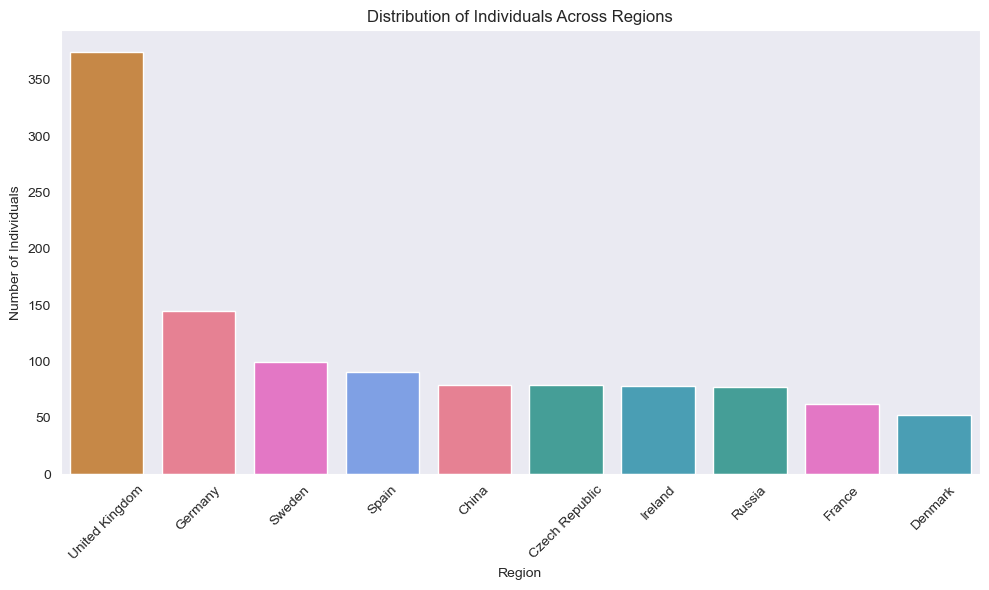

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

relevent_cols=['Genetic ID','Political Entity']
df_plot=df_chrY_info_final[relevent_cols]
palette = sns.color_palette('husl', n_colors=10)

sns.set_style(style='dark')

plt.figure(figsize=(10, 6))
sns.countplot(data=df_plot, x='Political Entity', order=df_plot['Political Entity'].value_counts().head(10).index,hue='Political Entity',palette=palette,legend=False)
plt.title('Distribution of Individuals Across Regions')
plt.xlabel('Region')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
